In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
#%% separate independent / dependent features
X = np.array(df.loc[ :, df.columns != 'output'])
y = np.array(df['output'])

print(f"X: {X.shape}, y: {y.shape}")

X: (303, 13), y: (303,)


In [5]:
#%% Train / Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [6]:
#%% scale the data
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [7]:
#%% network class
class NeuralNetworkFromScratch:
    def __init__(self, LR, X_train, y_train, X_test, y_test):
        self.w = np.random.randn(X_train.shape[1])
        self.b = np.random.randn()
        self.LR = LR
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.L_train = []
        self.L_test = []

    def activation(self, x):
        # sigmoid in our case
        return 1 / (1 + np.exp(-x))

    def dactivation(self, x):
        # derivative of sigmoid
        return self.activation(x) * (1 - self.activation(x))

    def forward(self, X):
        hidden_1 = np.dot(X, self.w) + self.b
        activate_1 = self.activation(hidden_1)
        return activate_1

    def backward(self, X, y_true):
        # calc gradients
        hidden_1 = np.dot(X, self.w) + self.b
        y_pred = self.forward(X)
        dL_dpred = 2 * (y_pred - y_true)
        dpred_dhidden1 = self.dactivation(hidden_1)
        dhidden1_db = 1
        dhidden1_dw = X

        dL_db = dL_dpred * dpred_dhidden1 * dhidden1_db
        dL_dw = dL_dpred * dpred_dhidden1 * dhidden1_dw
        return dL_db, dL_dw

    def optimizer(self, dL_db, dL_dw):
        # update weights
        self.b = self.b - dL_db * self.LR
        self.w = self.w - dL_dw * self.LR

    def train(self, ITERATIONS):
        for i in range(ITERATIONS):
            # random position
            random_pos = np.random.randint(len(self.X_train))

            # forward pass
            y_train_true = self.y_train[random_pos]
            y_train_pred = self.forward(self.X_train[random_pos])

            # calc training loss
            L = np.sum(np.square(y_train_pred - y_train_true))
            self.L_train.append(L)

            # calc gradients
            dL_db, dL_dw = self.backward(
                self.X_train[random_pos], self.y_train[random_pos]
            )
            # update weights
            self.optimizer(dL_db, dL_dw)

            # calc error at every epoch end
            L_sum = 0
            for j in range(len(self.X_test)):
                y_true = self.y_test[j]
                y_pred = self.forward(self.X_test[j])
                L_sum += np.square(y_pred - y_true)
            self.L_test.append(L_sum)

        return "training successfully finished"

In [8]:
#%% Hyper parameters
LR = 0.1
ITERATIONS = 1000

In [9]:
#%% model instance and training
nn = NeuralNetworkFromScratch(LR=LR, X_train=X_train_scale, y_train=y_train, X_test=X_test_scale, y_test=y_test)
nn.train(ITERATIONS=ITERATIONS)

'training successfully finished'

<Axes: >

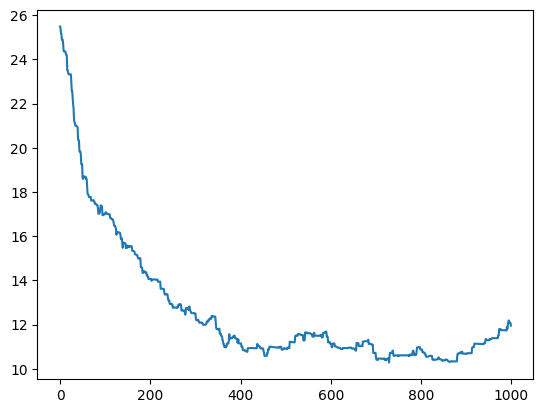

In [10]:
# %% check losses
sns.lineplot(x=list(range(len(nn.L_test))), y=nn.L_test)

In [11]:
# %% iterate over test data
total = X_test_scale.shape[0]
correct = 0
y_preds = []
for i in range(total):
    y_true = y_test[i]
    y_pred = np.round(nn.forward(X_test_scale[i]))
    y_preds.append(y_pred)
    correct += 1 if y_true == y_pred else 0

In [15]:
# %% Calculate Accuracy
acc = correct / total
acc

0.7377049180327869

In [13]:
# %% Baseline Classifier
from collections import Counter
Counter(y_test)

Counter({1: 31, 0: 30})

In [14]:
# %% Confusion Matrix
confusion_matrix(y_true = y_test, y_pred = y_preds)

array([[22,  8],
       [ 8, 23]])